In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.278186  1.064365  1.061374 -0.536059 -0.061534 -0.092391  0.351515   
  1  -0.317585  0.291666  0.155068 -0.452513 -0.265190 -0.329173  0.091862   
  2   1.426259 -0.403463 -0.908970  0.206191 -0.041593 -0.951145 -0.387323   
  3  -0.263310 -0.197614  1.791097  1.496403  0.545356  0.532461  0.458593   
  4   0.537814 -0.463140  0.289718  0.242818 -0.135166 -0.607340  0.082744   
  5  -0.168105  0.458814 -0.106380  0.417263 -0.977718  0.004879  0.860696   
  6   0.470885  0.608260  0.265351  0.504462  0.636159 -0.510588 -0.116716   
  7   0.881384 -0.091843  0.787584  0.256395  0.321896  0.027094  0.126936   
  8   0.052732  0.007815 -0.717549 -0.143557 -0.517266  0.430952  0.756564   
  9   0.023285 -0.688046  0.470736 -0.647906 -0.253939 -0.478504  0.322419   
  10  0.358955 -0.080942 -0.419744 -0.802597 -0.349840 -0.729853 -0.005191   
  11 -0.225064  0.144718 -0.188085  0.835814 -0.434692 -0.786656  0.513542   
  12  0.642199  0.848396 -1.291373 -0.475726 -0.615361 -0.728253  0.588890   
  13  0.224097  0.189842  0.672661 -1.075630 -1.354831 -0.077995 -0.682384   
  14  0.439153  0.227348  0.170426 -0.454634 -0.071036 -0.647896 -0.643956   
  15 -0.075951  0.819281  0.161109 -0.219533 -0.253758 -0.216909  0.138957   
  16  0.377970 -0.454582  0.031320  0.252496 -0.140449  0.076946  0.922774   
  17  0.799060  0.767634  0.743586 -0.165574 -0.192827 -0.496111  0.544070   
  18  0.023940 -0.459706 -0.544394  1.055742 -0.525327 -0.554340 -0.082136   
  19  0.186604  0.937707  1.122433  0.398513  0.114681 -0.017667  0.697948   
  20 -0.372882  0.115162 -0.108476 -0.735933 -0.405369 -0.141327  0.295764   
  21 -0.286814 -0.687113 -0.423584  0.740015  0.377038  0.090644  0.757267   
  22 -0.411874 -0.112808 -1.367551 -1.231095 -0.245018 -1.397512  0.329809   
  23 -0.168021 -0.485478  0.629247  0.463996  0.620018  0.149028 -0.117892   
  24  0.970685 -0.025658  0.036279  0.788698  0.530061  0.063224 -0.364956   
1 0   1.049322  0.155938  0.516853  0.398484  0.475545 -0.288509 -0.204413   
  1  -0.596491 -0.829322  0.732938  0.311222 -0.080517 -0.355781  0.852423   
  2   0.907287  0.566593  0.169108  0.836025  0.341868 -0.949548 -0.551356   
  3  -0.962023 -1.110513  0.085182 -0.361839  0.276975 -0.794594  0.850074   
  4   0.510258 -0.313460 -0.470336 -0.247086  0.097626 -0.742744  0.047602   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.158711  0.814805  0.355539  ...  0.625770 -0.606292  0.177484   
  1   0.243474  0.234773  0.093586  ...  0.675631 -0.488139  0.463093   
  2  -0.611548  0.350261  1.262195  ...  0.729142  0.491646  0.035591   
  3   0.126643  0.189549  0.563362  ...  1.269194  0.934524  0.305035   
  4   0.430112  0.862402  0.268065  ... -0.506307 -0.442085 -0.278593   
  5   0.465423 -0.264945  0.812034  ...  0.105175  0.752965  0.922103   
  6  -0.233055 -0.301344  0.368321  ...  0.326144  0.613079  0.362839   
  7   0.728405 -0.225801  0.837308  ...  0.191418  0.131181  0.351461   
  8   1.449227  1.010587  0.657740  ...  0.261414  0.352297 -0.101153   
  9  -0.601966 -0.384529  0.231180  ...  0.563005  0.420802  1.500380   
  10  0.811393  0.457086 -0.292673  ...  0.712132 -0.229169 -0.465089   
  11 -0.616917 -0.333770  0.907084  ...  0.560670 -0.007227  0.194545   
  12 -0.163204  0.313961  0.344116  ...  0.307055  0.922502  0.963245   
  13 -0.140239 -0.196035 -0.525449  ...  0.534521 -0.266864  0.065198   
  14  0.063156  0.757759  0.656703  ... -0.331125 -0.027855 -0.505140   
  15 -0.456397 -0.366162  0.314205  ...  0.331964  0.011998  0.452875   
  16  0.447445 -0.102244  0.120667  ...  0.323709  0.191778  0.642738   
  17  0.218163 -0.371845  0.164659  ...  0.378522  0.505564  1.308157   
  18 -0.880653  0.616390  0.758158  ...  0.649618  0.639045  0.358835   
  19  0.193550 -0.094830  0.453148  ...  0.346348  0.256155  0.382811   
  20  0.064067  0.072231  0.142475  ...  0.967747  0.604520 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %   97.5 %
D  1.062222  0.040336  26.334113  7.804178e-153  0.983164  1.14128


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



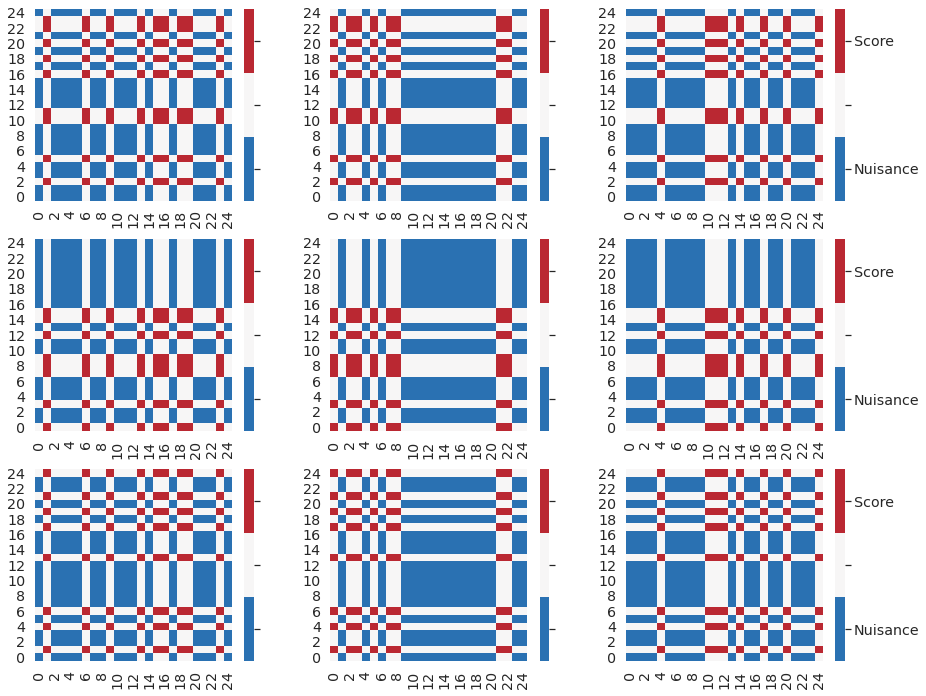

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



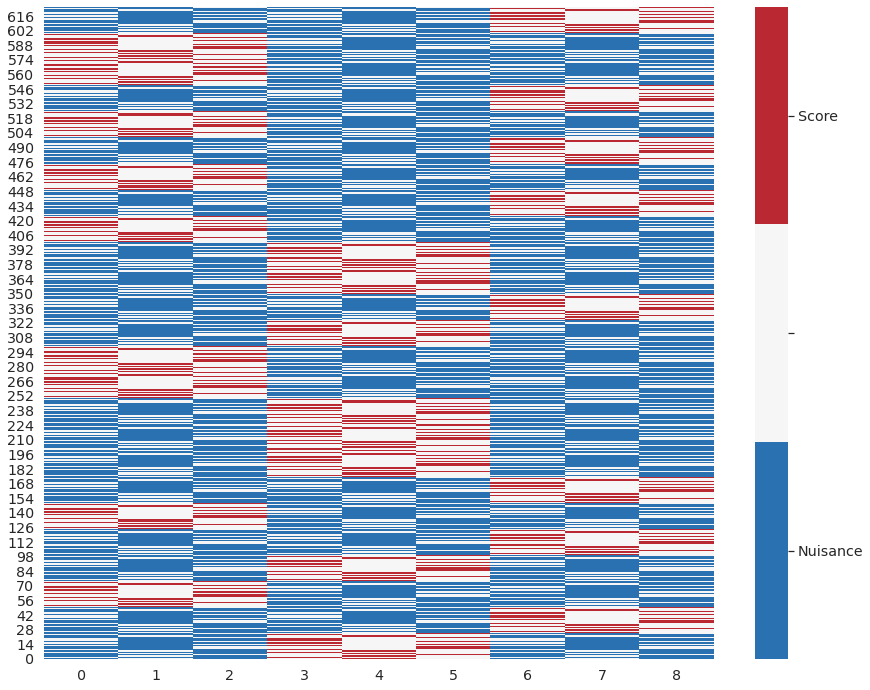

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])